# Submission Max-Paul & Moritz

In [66]:
from mymodel import init_my_model
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml

### Read in data

In [67]:
mymodel = init_my_model(activation_function=torch.nn.ReLU())
mymodel.load_state_dict(torch.load("out_ml/model.pt", map_location="cpu"))

min_max = yaml.safe_load(open("out_ml/min_max.yaml", "r"))
print(yaml.dump(min_max, default_flow_style=False, sort_keys=False))

u_min, u_max = min_max["labels"]["u"]["min"], min_max["labels"]["u"]["max"]
v_min, v_max = min_max["labels"]["v"]["min"], min_max["labels"]["v"]["max"]

inputs:
  u:
    max: 1.5
    min: 0.0
labels:
  u:
    max: 1.5000002831997326
    min: -0.25587589567699415
  v:
    max: 0.20091928070534526
    min: -0.3722223503811245



In [68]:
#HELPERS
def load_dataset(path: str):
    with torch.serialization.safe_globals([torch.utils.data.dataset.TensorDataset]):
        return torch.load(path, map_location="cpu")

def unnormalize_uv(t: torch.Tensor) -> torch.Tensor:
    # t shape: [B, 2, H, W]
    t_out = t.clone()
    t_out[:, 0, :, :] = t[:, 0, :, :] * (u_max - u_min) + u_min
    t_out[:, 1, :, :] = t[:, 1, :, :] * (v_max - v_min) + v_min
    return t_out

## Train vs. Validation Loss Plot

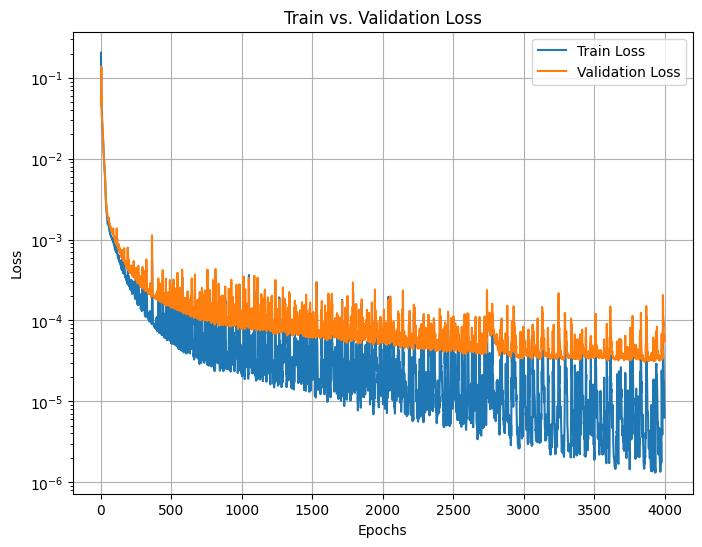

In [69]:
train_losses = np.load("out_ml/train_losses.npy")
val_losses = np.load("out_ml/val_losses.npy")

plt.figure(figsize=(8,6))
plt.semilogy(train_losses, label='Train Loss')
plt.semilogy(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs. Validation Loss')
plt.legend()
plt.grid()
plt.show()

## Model Details
- number of trainable parameters of your best model
- layout

In [70]:
print(mymodel)
total_params = sum(p.numel() for p in mymodel.parameters() if p.requires_grad)
print(f'Total trainable parameters: {total_params}')

Sequential(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu2): ReLU()
  (conv3): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu3): ReLU()
  (conv4): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu4): ReLU()
  (conv5): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu5): ReLU()
  (conv6): Conv2d(16, 16, kernel_size=(7, 7), stride=(1, 1), padding=same)
  (relu6): ReLU()
  (conv7): Conv2d(16, 2, kernel_size=(7, 7), stride=(1, 1), padding=same)
)
Total trainable parameters: 65170


## Evaluation metrics
- the measured evaluation metrics of your best model for train, val, test RMSE, MAE on the un-normed predicted u, v fields


In [71]:
@torch.no_grad()
def compute_metrics(model, dataset):
    model.eval()

    se_u = 0.0
    se_v = 0.0
    ae_u = 0.0
    ae_v = 0.0
    n_u = 0
    n_v = 0

    pred = mymodel(dataset.tensors[0])
    yb = dataset.tensors[1]

    # Un-normalize predictions and targets to original physical scale
    pred_unnorm = unnormalize_uv(pred)
    yb_unnorm = unnormalize_uv(yb)

    du = pred_unnorm[:, 0, :, :] - yb_unnorm[:, 0, :, :]
    dv = pred_unnorm[:, 1, :, :] - yb_unnorm[:, 1, :, :]

    se_u = torch.sum(du ** 2).item()
    se_v = torch.sum(dv ** 2).item()
    ae_u = torch.sum(torch.abs(du)).item()
    ae_v = torch.sum(torch.abs(dv)).item()
    n_u = du.numel()
    n_v = dv.numel()

    rmse_u = (se_u / n_u) ** 0.5
    rmse_v = (se_v / n_v) ** 0.5
    mae_u = ae_u / n_u
    mae_v = ae_v / n_v

    return {
        "RMSE_u": rmse_u,
        "RMSE_v": rmse_v,
        "MAE_u": mae_u,
        "MAE_v": mae_v
    }

In [72]:
# Load datasets
train_ds = load_dataset("out_ml/train_dataset.pt")
val_ds = load_dataset("out_ml/validation_dataset.pt")
test_ds = load_dataset("out_ml/test_dataset.pt")
all_ds = torch.utils.data.TensorDataset(
    torch.cat([train_ds.tensors[0], val_ds.tensors[0], test_ds.tensors[0]], dim=0),
    torch.cat([train_ds.tensors[1], val_ds.tensors[1], test_ds.tensors[1]], dim=0)
)
print(f"All dataset size: {len(all_ds)} samples")
print(f"shape train: {train_ds.tensors[0].shape}, val: {val_ds.tensors[0].shape}, test: {test_ds.tensors[0].shape}, all: {all_ds.tensors[0].shape}")

# Compute metrics
metrics_train = compute_metrics(mymodel, train_ds)
metrics_val = compute_metrics(mymodel, val_ds)
metrics_test = compute_metrics(mymodel, test_ds)
metrics_all = compute_metrics(mymodel, all_ds)

# Pretty print
def print_metrics(name, m):
    print(f"{name}: RMSE_u={m['RMSE_u']:.6f}, RMSE_v={m['RMSE_v']:.6f}, MAE_u={m['MAE_u']:.6f}, MAE_v={m['MAE_v']:.6f}")

print_metrics("Train", metrics_train)
print_metrics("Val", metrics_val)
print_metrics("Test", metrics_test)
print_metrics("All", metrics_all)

All dataset size: 101 samples
shape train: torch.Size([80, 1, 21, 21]), val: torch.Size([11, 1, 21, 21]), test: torch.Size([10, 1, 21, 21]), all: torch.Size([101, 1, 21, 21])
Train: RMSE_u=0.003351, RMSE_v=0.001868, MAE_u=0.002593, MAE_v=0.001440
Val: RMSE_u=0.007144, RMSE_v=0.005551, MAE_u=0.003558, MAE_v=0.002240
Test: RMSE_u=0.003655, RMSE_v=0.002321, MAE_u=0.002853, MAE_v=0.001734
All: RMSE_u=0.003972, RMSE_v=0.002579, MAE_u=0.002724, MAE_v=0.001556


## Sample Predictions

In [73]:
with torch.serialization.safe_globals([torch.utils.data.dataset.TensorDataset]):
    test_dataset = torch.load("out_ml/test_dataset.pt", map_location="cpu")
print(
    f"shape of loaded dataset: Input: {test_dataset.tensors[0].shape} and labels: {test_dataset.tensors[1].shape}"
)

shape of loaded dataset: Input: torch.Size([10, 1, 21, 21]) and labels: torch.Size([10, 2, 21, 21])


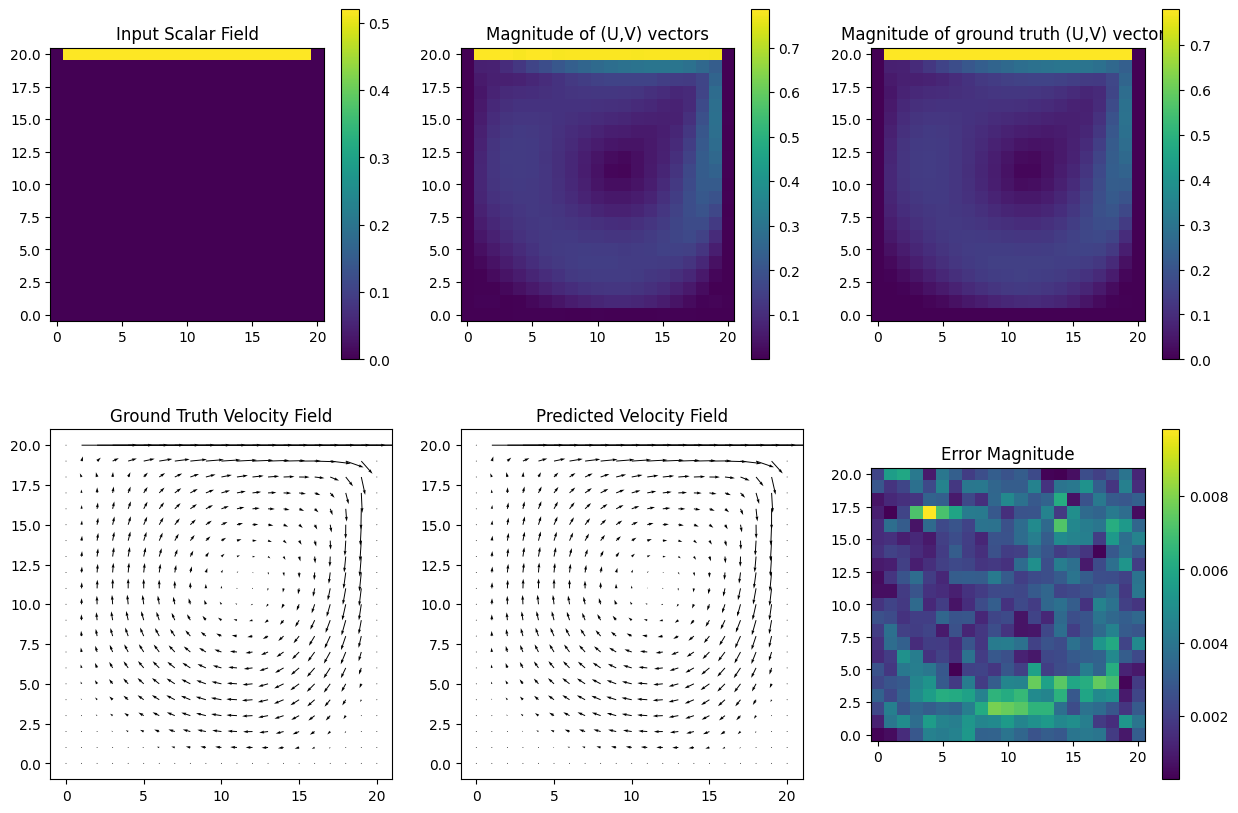

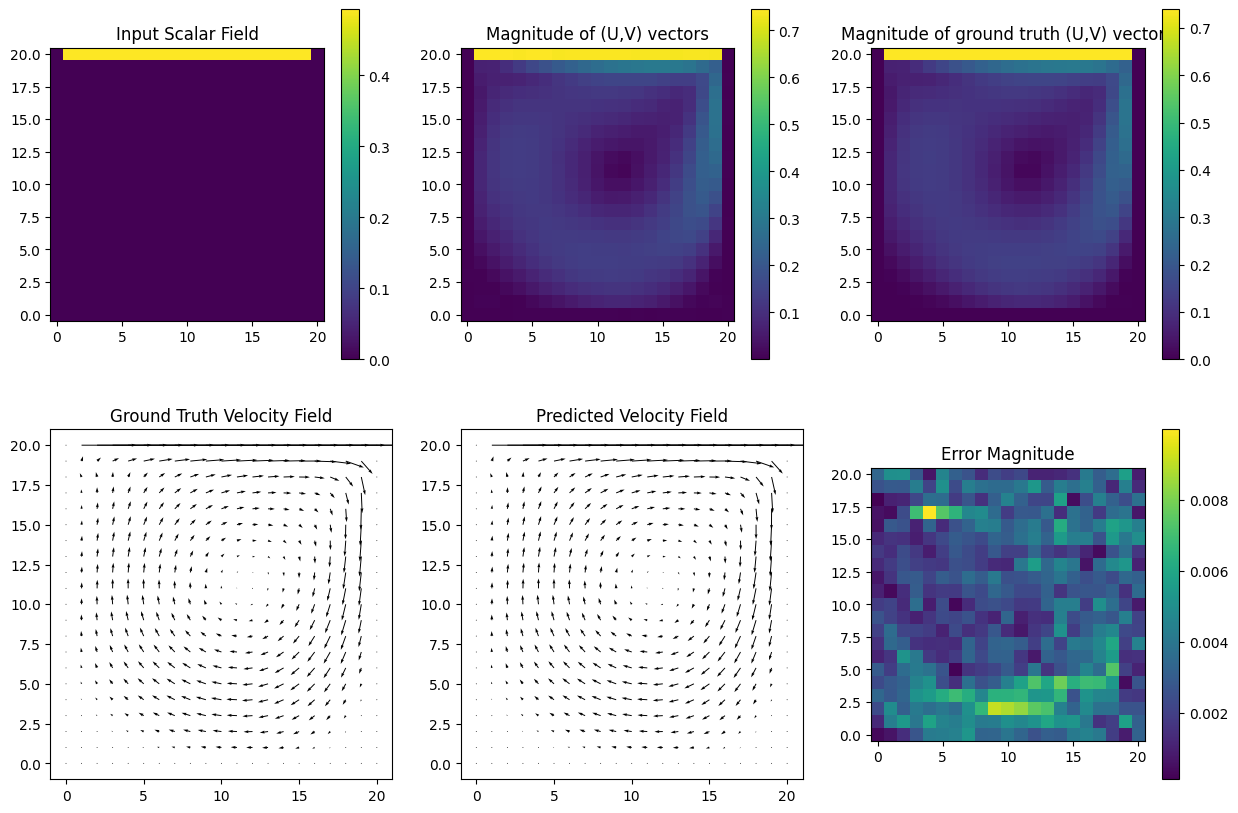

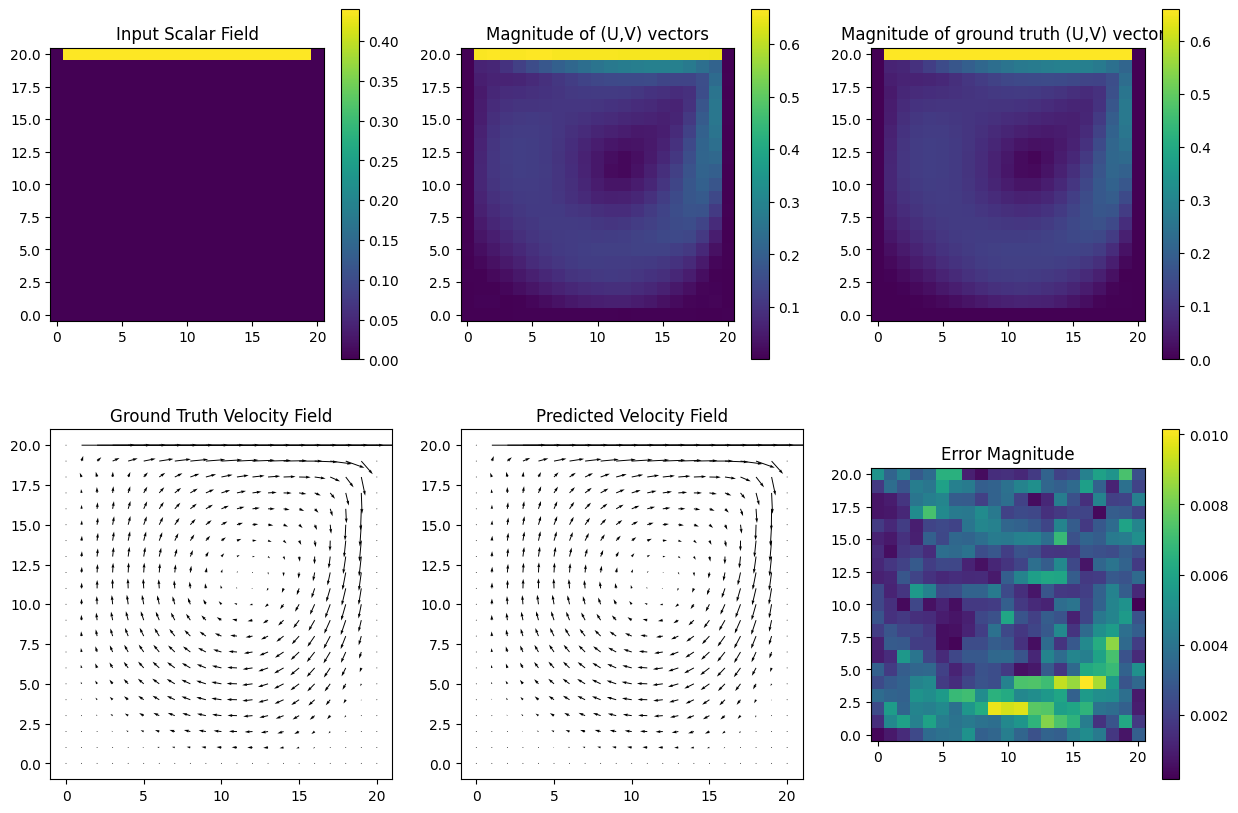

In [74]:
num_samples = 3
pred_indices = np.random.choice(len(test_dataset), num_samples, replace=False)
for idx in pred_indices:
    input_sample = test_dataset.tensors[0][idx].unsqueeze(0)
    label_sample = test_dataset.tensors[1][idx].unsqueeze(0)
    with torch.no_grad():
        pred_sample = mymodel(input_sample)
    
    input_sample_np = input_sample.squeeze(0).numpy()
    label_sample_np = label_sample.squeeze(0).numpy()
    pred_sample_np = pred_sample.squeeze(0).numpy()
    
    # Un-normalize
    u_min, u_max = min_max["labels"]['u']["min"], min_max["labels"]['u']["max"]
    v_min, v_max = min_max["labels"]['v']["min"], min_max["labels"]['v']["max"]
    
    label_u = label_sample_np[0, :, :] * (u_max - u_min) + u_min
    label_v = label_sample_np[1, :, :] * (v_max - v_min) + v_min
    pred_u = pred_sample_np[0, :, :] * (u_max - u_min) + u_min
    pred_v = pred_sample_np[1, :, :] * (v_max - v_min) + v_min
    
    X, Y = np.meshgrid(np.arange(label_u.shape[1]), np.arange(label_u.shape[0]))
    
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.title('Input Scalar Field')
    plt.imshow(input_sample_np[0, :, :], cmap='viridis', origin='lower')
    plt.colorbar()
    
    plt.subplot(2, 3, 4)
    plt.quiver(X, Y, label_u, label_v)
    plt.title('Ground Truth Velocity Field')
    
    plt.subplot(2, 3, 5)
    plt.quiver(X, Y, pred_u, pred_v)
    plt.title('Predicted Velocity Field')

    plt.subplot(2, 3, 2)
    plt.title("Magnitude of (U,V) vectors")
    magnitude = np.sqrt(pred_u**2 + pred_v**2)
    plt.imshow(magnitude, cmap='viridis', origin='lower')
    plt.colorbar()

    plt.subplot(2, 3, 3)
    plt.title("Magnitude of ground truth (U,V) vectors")
    magnitude_gt = np.sqrt(label_u**2 + label_v**2)
    plt.imshow(magnitude_gt, cmap='viridis', origin='lower')
    plt.colorbar()

    plt.subplot(2, 3, 6)
    plt.title("Error Magnitude")
    error_magnitude = np.sqrt((pred_u - label_u)**2 + (pred_v - label_v)**2)
    plt.imshow(error_magnitude, cmap='viridis', origin='lower')
    plt.colorbar()
    
    plt.show()

## Out of distribution test

- visualizations of the three out-of-distribution test samples (have an explanation of what you can see at hand for the oral exam)

In [79]:
def try_model_on_input(input_sample):
    pred_sample_1 = mymodel(torch.tensor(input_sample, dtype=torch.float32)).detach().numpy()

    plt.figure(figsize=(15, 10))
    plt.subplot(2, 3, 1)
    plt.title('Input Scalar Field')
    plt.imshow(input_sample[0, :, :], cmap='viridis', origin='lower')
    plt.colorbar()

    plt.subplot(2, 3, 2)
    plt.quiver(pred_sample_1[0, :, :], pred_sample_1[1, :, :])
    plt.title('Predicted Velocity Field')

    plt.subplot(2, 3, 3)
    plt.title("Magnitude (U,V) vector")
    magnitude = np.sqrt(pred_sample_1[0,:,:]**2 + pred_sample_1[1,:,:]**2)
    plt.imshow(magnitude, cmap='viridis', origin='lower')
    plt.colorbar()

    plt.subplot(2, 3, 4)
    plt.title('U Field')
    plt.imshow(pred_sample_1[0, :, :], cmap='viridis', origin='lower')
    plt.colorbar()

    plt.subplot(2, 3, 5)
    plt.title('V Field')
    plt.imshow(pred_sample_1[1, :, :], cmap='viridis', origin='lower')
    plt.colorbar()

    plt.show()

### Different location of the boundary condition

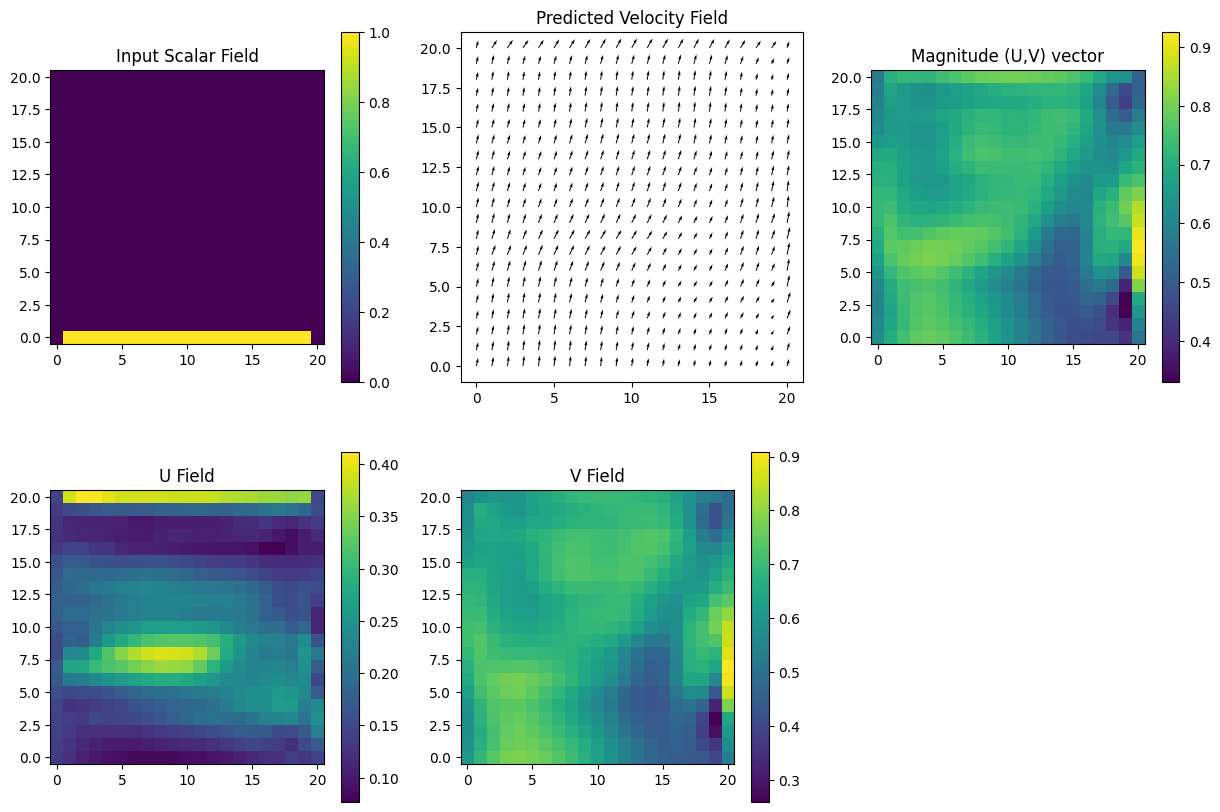

In [76]:
input_sample_1 = np.zeros(test_dataset.tensors[0][0].unsqueeze(0).size()[1:])
input_sample_1[:, 0, 1:-1] = 1.0
try_model_on_input(input_sample_1)

### Out of dist value for boundary condition

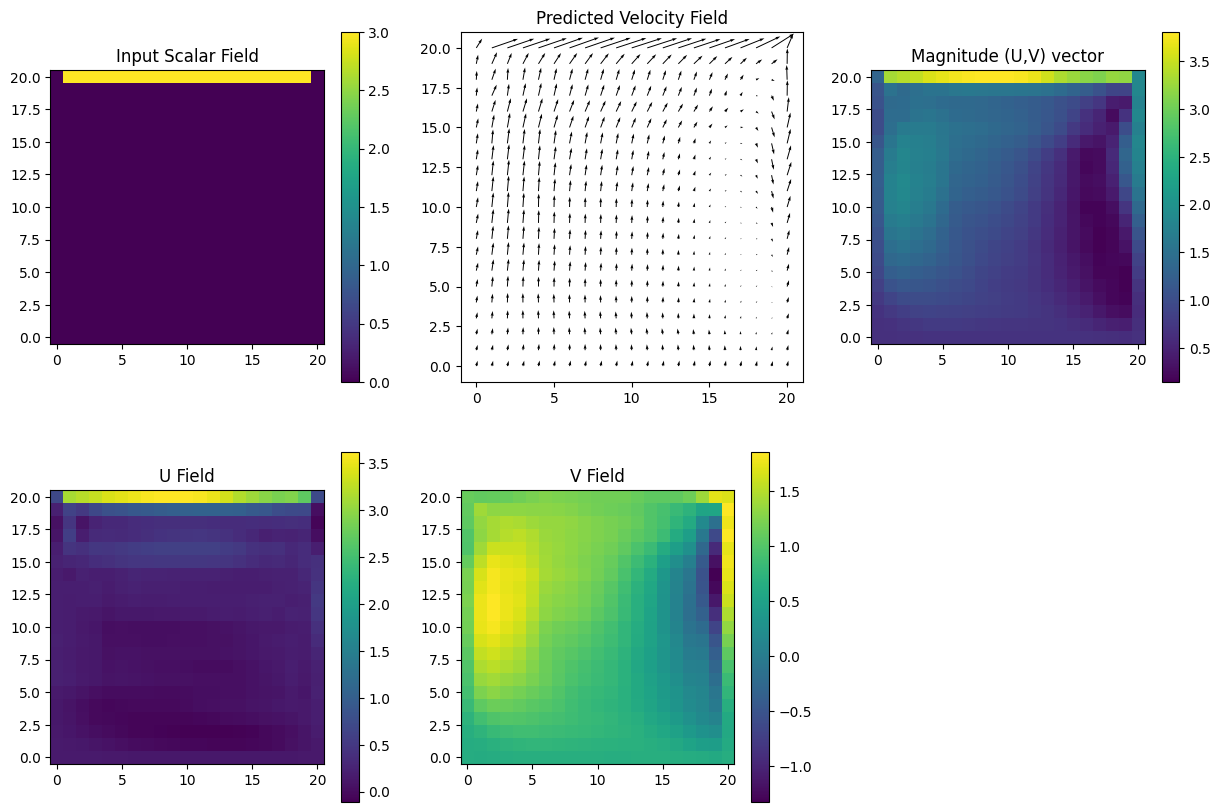

In [77]:
input_sample_2 = np.zeros(test_dataset.tensors[0][0].unsqueeze(0).size()[1:])
input_sample_2[:, -1, 1:-1] = 3.0
try_model_on_input(input_sample_2)

### Different direction of the boundary condition

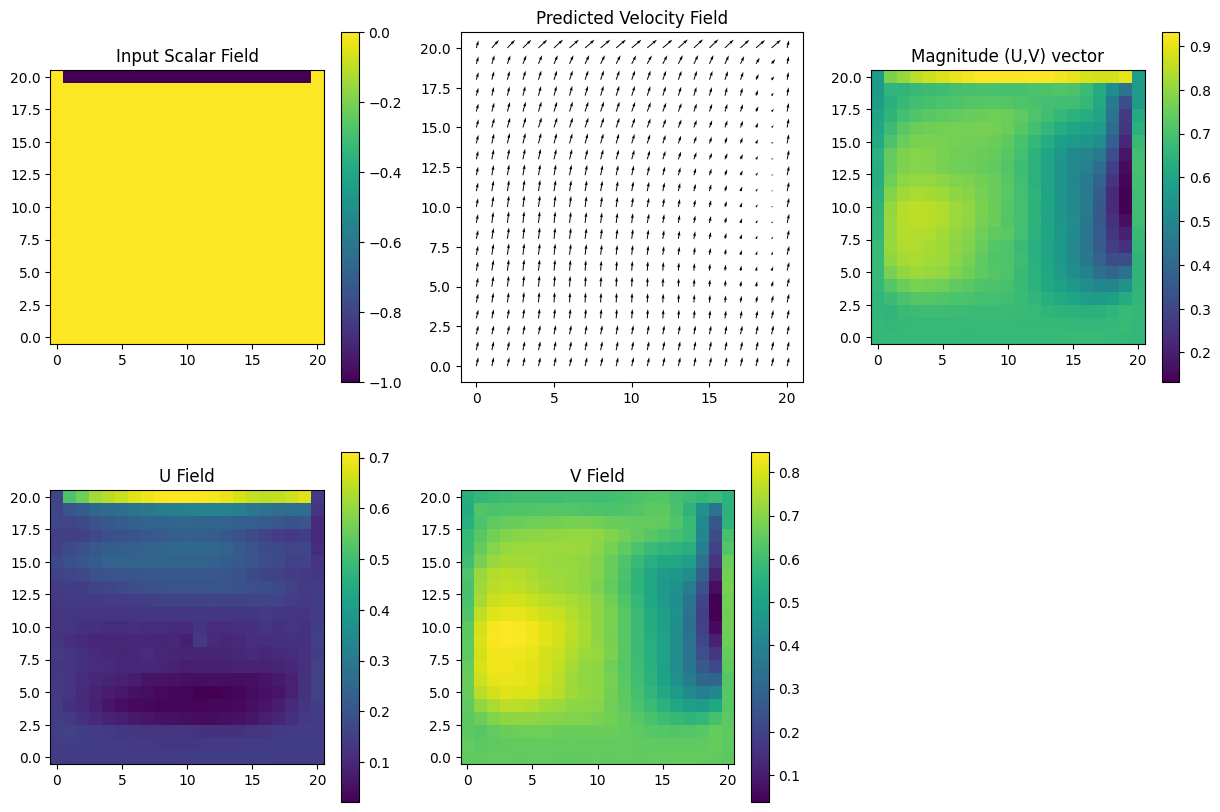

In [78]:
input_sample_2 = np.zeros(test_dataset.tensors[0][0].unsqueeze(0).size()[1:])
input_sample_2[:, -1, 1:-1] = -1.0
try_model_on_input(input_sample_2)